<a href="https://colab.research.google.com/github/nathanyap17/ssac_2025/blob/master/toi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://www.spaceappschallenge.org/2025/find-a-team/borneo-data-pioneers/" target="_blank">
    <img src="https://github.com/nathanyap17/ssac_2025/blob/master/assets/BDP_Profile.png?raw=1" width="200" alt="Borneo Data Pioneers"  />
    </a>
</p>

<h1 align=center><font size = 5>Data Analysis & Engineering on TOI</font></h1>

# TESS Object of Interest


##### This dataset is a comprehensive list of all confirmed exoplanets, planetary candidates (PC), false positives (FP), ambiguous planetary candidates (APC), and known planets (KP, previously identified) identified by the TESS mission so far. See column “TFOWPG Disposition” for classification.

toi: The TOI identifier. This is critical for fetching the actual TESS light curve data. \
tid: TESS Input Catalog (TIC) ID. Another identifier that can be used to fetch light curves. \
tfopwg_disp: THIS IS YOUR DEPENDENT VARIABLE (LABEL)! \
FP: False Positive \
PC: Planetary Candidate \
KP: Confirmed Planet (Kepler Planet - likely confirmed by Kepler data or follow-up) \
APC: Awaiting Planetary Candidate (Essentially a PC, but awaiting further vetting) \
You'll map these to numerical labels (e.g., 0, 1, 2 or consolidate as needed). \
pl_orbper: Orbital Period (days). Essential for phase-folding light curves. \
pl_tranmid: Transit Midpoint (BJD). Essential for phase-folding light curves. \
pl_trandurh: Transit Duration (hours). Important for characterizing the transit. \
pl_trandep: Transit Depth (parts per thousand, ppt). Another key transit characteristic. \
st_teff: Stellar Effective Temperature (Kelvin).
Crucial for identifying M-dwarfs and estimating habitability. \
st_rad: Stellar Radius (solar radii). Influences transit depth and planet radius calculation.
pl_rade: Planetary Radius (Earth radii).
A key derived parameter; useful for determining HZ potential.
pl_insol: Incident Stellar Flux (Earth flux units). Direct measure for Habitability Zone (HZ) assessment.
pl_eqt: Equilibrium Temperature (Kelvin). Another direct measure for HZ.

### Import Dependencies & Libraries

In [ ]:
# Install nessary packages
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

### 1. Importing Data Sets

#### Load the csv file:

In [ ]:
file_name = "TOI_2025_org.csv"
df = pd.read_csv(file_name, header=0)

In [ ]:
df.head()

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,NaN,...,-0.07,0,1,2.16986,0.072573,-0.072573,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,NaN,...,-0.09,0,1,2.01000,0.090000,-0.090000,0,1,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,NaN,...,NaN,0,1,5.73000,NaN,NaN,0,1,2019-07-24 15:58:33,2022-07-11 16:02:02
3,4,1003.01,1003,106997505,1.069975e+08,1,FP,07h22m14.39s,110.559945,NaN,...,-1.64,0,1,NaN,NaN,NaN,0,1,2019-07-24 15:58:33,2022-02-23 10:10:02
4,5,1004.01,1004,238597883,2.385979e+08,1,FP,08h08m42.77s,122.178195,NaN,...,-0.07,0,1,2.15000,0.060000,-0.060000,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              7668 non-null   int64  
 1   toi                7668 non-null   float64
 2   toipfx             7668 non-null   int64  
 3   tid                7668 non-null   int64  
 4   ctoi_alias         7668 non-null   float64
 5   pl_pnum            7668 non-null   int64  
 6   tfopwg_disp        7668 non-null   object 
 7   rastr              7668 non-null   object 
 8   ra                 7668 non-null   float64
 9   decstr             7668 non-null   object 
 10  dec                7668 non-null   float64
 11  st_pmra            7534 non-null   float64
 12  st_pmraerr1        7534 non-null   float64
 13  st_pmraerr2        7534 non-null   float64
 14  st_pmralim         7534 non-null   float64
 15  st_pmrasymerr      7534 non-null   float64
 16  st_pmdec           7534 

In [ ]:
# Extracting sample data
df.head(30).to_csv('TOI_sample.csv', index=False)

### 2. Data Wrangling

##### Dealing with missing values and data cleaning

In [ ]:
# Identify missing values in columns
missing_values = df.isnull()
for column in missing_values.columns.values.tolist():
    print(column)
    print(missing_values[column].value_counts())
    print("\n")

rowid
rowid
False    7668
Name: count, dtype: int64


toi
toi
False    7668
Name: count, dtype: int64


toipfx
toipfx
False    7668
Name: count, dtype: int64


tid
tid
False    7668
Name: count, dtype: int64


ctoi_alias
ctoi_alias
False    7668
Name: count, dtype: int64


pl_pnum
pl_pnum
False    7668
Name: count, dtype: int64


tfopwg_disp
tfopwg_disp
False    7668
Name: count, dtype: int64


rastr
rastr
False    7668
Name: count, dtype: int64


ra
ra
False    7668
Name: count, dtype: int64


decstr
decstr
False    7668
Name: count, dtype: int64


dec
dec
False    7668
Name: count, dtype: int64


st_pmra
st_pmra
False    7534
True      134
Name: count, dtype: int64


st_pmraerr1
st_pmraerr1
False    7534
True      134
Name: count, dtype: int64


st_pmraerr2
st_pmraerr2
False    7534
True      134
Name: count, dtype: int64


st_pmralim
st_pmralim
False    7534
True      134
Name: count, dtype: int64


st_pmrasymerr
st_pmrasymerr
False    7534
True      134
Name: count, dtype: int64




In [ ]:
# Listing out columns with NaN values
mv_col = df.columns[df.isnull().any()].tolist()
df[mv_col].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7562 entries, 0 to 7667
Empty DataFrame


In [ ]:
# Removing columns with entirely NaN values
df.dropna(axis=1, how='all', inplace=True)

In [ ]:
# Astrometry columns - Check if 10% of the rows are missing
df['st_pmra'].isnull().sum()
per = df['st_pmra'].isnull().sum() / len(df['st_pmra']) # OUTPUT: 1.74% of the rows are missing

# Impute with means
df['st_pmra'].fillna(df['st_pmra'].mean(), inplace=True)
df['st_pmra'].isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_20836\1395275276.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['st_pmra'].fillna(df['st_pmra'].mean(), inplace=True)


np.int64(0)

In [ ]:
# Proper motion in Dec - Check if 10% of the rows are missing
df['st_pmdec'].isnull().sum()
per = df['st_pmdec'].isnull().sum() / len(df['st_pmdec']) * 100 # OUTPUT: 1.74% of the rows are missing

# Impute with means
df['st_pmdec'].fillna(df['st_pmdec'].mean(), inplace=True)
df['st_pmdec'].isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_20836\234793054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['st_pmdec'].fillna(df['st_pmdec'].mean(), inplace=True)


np.int64(0)

In [ ]:
# For all columns of relative errors - replace with mean/median
relErr = ['st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmrasymerr', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim']

for col in relErr:
    df[col].fillna(df[col].mean(), inplace=True)
    print(df[col].isnull().sum())
    print(df[col].value_counts())
    print('\n')

C:\Users\USER\AppData\Local\Temp\ipykernel_20836\1053118530.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


0
st_pmraerr1
0.042    188
0.038    172
0.045    167
0.040    164
0.039    159
        ... 
2.010      1
2.170      1
0.817      1
1.699      1
2.119      1
Name: count, Length: 598, dtype: int64


0
st_pmraerr2
-0.042    188
-0.038    172
-0.045    167
-0.040    164
-0.039    159
         ... 
-2.010      1
-2.170      1
-0.817      1
-1.699      1
-2.119      1
Name: count, Length: 598, dtype: int64


0
st_pmralim
0.0    7668
Name: count, dtype: int64


0
st_pmrasymerr
1.0    7668
Name: count, dtype: int64


0
st_pmdecerr1
0.044    199
0.042    193
0.047    185
0.041    184
0.046    183
        ... 
3.082      1
1.194      1
2.709      1
0.397      1
0.206      1
Name: count, Length: 595, dtype: int64


0
st_pmdecerr2
-0.044    199
-0.042    193
-0.047    185
-0.041    184
-0.046    183
         ... 
-3.082      1
-1.194      1
-2.709      1
-0.397      1
-0.206      1
Name: count, Length: 595, dtype: int64


0
st_pmdeclim
0.0    7668
Name: count, dtype: int64




In [ ]:
# Replacing NaN values in columns
df['st_pmdeclim'].fillna(0, inplace=True)
df['st_pmdeclim'].value_counts()

C:\Users\USER\AppData\Local\Temp\ipykernel_20836\2086508548.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['st_pmdeclim'].fillna(0, inplace=True)


st_pmdeclim
0.0    7668
Name: count, dtype: int64

In [ ]:
# Dealing with the rest of the data columns with missing values
# Proper Motion Symmetry
df['st_pmdecsymerr'].fillna(0, inplace=True)  # zero-fill

# Transit Timing Errors
df['pl_tranmiderr1'].fillna(0, inplace=True)  # zero-fill
df['pl_tranmiderr2'].fillna(0, inplace=True)  # zero-fill

# Orbital Period
df.dropna(subset=['pl_orbper'], inplace=True)  # drop rows with NaN

# Orbital Period Errors
df['pl_orbpererr1'].fillna(df['pl_orbpererr1'].median(), inplace=True)  # median
df['pl_orbpererr2'].fillna(df['pl_orbpererr2'].median(), inplace=True)  # median

# Transit Duration Errors
df['pl_trandurherr1'].fillna(df['pl_trandurherr1'].median(), inplace=True)  # median
df['pl_trandurherr2'].fillna(df['pl_trandurherr2'].median(), inplace=True)  # median

# Transit Depth Errors
df['pl_trandeperr1'].fillna(df['pl_trandeperr1'].median(), inplace=True)  # median
df['pl_trandeperr2'].fillna(df['pl_trandeperr2'].median(), inplace=True)  # median

# Planet Radius
df['pl_rade'].fillna(df['pl_rade'].median(), inplace=True)  # median

# Planet Radius Errors
df['pl_radeerr1'].fillna(df['pl_radeerr1'].median(), inplace=True)  # median
df['pl_radeerr2'].fillna(df['pl_radeerr2'].median(), inplace=True)  # median

# Insolation Flux
df['pl_insol'].fillna(df['pl_insol'].median(), inplace=True)  # median

# Equilibrium Temperature
df['pl_eqt'].fillna(df['pl_eqt'].median(), inplace=True)  # median

# Stellar Distance
df['st_dist'].fillna(df['st_dist'].mean(), inplace=True)  # mean

# Stellar Distance Errors
df['st_disterr1'].fillna(df['st_disterr1'].median(), inplace=True)  # median
df['st_disterr2'].fillna(df['st_disterr2'].median(), inplace=True)  # median

# Stellar Temperature
df['st_teff'].fillna(df['st_teff'].median(), inplace=True)  # median

# Stellar Temperature Errors
df['st_tefferr1'].fillna(df['st_tefferr1'].median(), inplace=True)  # median
df['st_tefferr2'].fillna(df['st_tefferr2'].median(), inplace=True)  # median

# Stellar Gravity
df['st_logg'].fillna(df['st_logg'].mean(), inplace=True)  # mean

# Stellar Gravity Errors
df['st_loggerr1'].fillna(df['st_loggerr1'].median(), inplace=True)  # median
df['st_loggerr2'].fillna(df['st_loggerr2'].median(), inplace=True)  # median

# Stellar Radius
df['st_rad'].fillna(df['st_rad'].median(), inplace=True)  # median

# Stellar Radius Errors
df['st_raderr1'].fillna(df['st_raderr1'].median(), inplace=True)  # median
df['st_raderr2'].fillna(df['st_raderr2'].median(), inplace=True)  # median

C:\Users\USER\AppData\Local\Temp\ipykernel_20836\2479021500.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['st_pmdecsymerr'].fillna(0, inplace=True)  # zero-fill
C:\Users\USER\AppData\Local\Temp\ipykernel_20836\2479021500.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



##### Data Formatting

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              7562 non-null   int64  
 1   toi                7562 non-null   float64
 2   toipfx             7562 non-null   int64  
 3   tid                7562 non-null   int64  
 4   ctoi_alias         7562 non-null   float64
 5   pl_pnum            7562 non-null   int64  
 6   tfopwg_disp        7562 non-null   object 
 7   rastr              7562 non-null   object 
 8   ra                 7562 non-null   float64
 9   decstr             7562 non-null   object 
 10  dec                7562 non-null   float64
 11  st_pmra            7562 non-null   float64
 12  st_pmraerr1        7562 non-null   float64
 13  st_pmraerr2        7562 non-null   float64
 14  st_pmralim         7562 non-null   float64
 15  st_pmrasymerr      7562 non-null   float64
 16  st_pmdec           7562 

### We can now conclude that...

This table describes columns from the TESS Objects of Interest (TOI) catalog (`TOI_sample.csv`) that directly relate to exoplanet detection, formatted for use in Jupyter Notebook (`ipynb`). These columns support the **Borneo ExoHunter** project, which uses a CNN to classify TESS light curves, reducing false positives (>80%) and boosting HZ planet detection, with a Sarawak-themed app for outreach.

| Name                  | Description                                                                 | Role in Exoplanet Detection                                                                 |
|-----------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| toi                   | TOI identifier (e.g., 1000.01), integer for star, decimal for signal        | Tracks specific exoplanet candidate for labeling and cross-referencing with light curves.    |
| toipfx                | Integer prefix of TOI (e.g., 1000), identifies target star                  | Links candidate to host star for fetching light curves via TIC ID.                          |
| tid                   | TESS Input Catalog ID (e.g., 50365310) of host star                        | Key to query MAST for raw light curves (time, flux) for CNN training.                       |
| ctoi_alias            | Community TOI alias (e.g., 50365310.01), TIC-based ID for object           | Alternative identifier for cross-referencing detections across databases.                   |
| pl_pnum               | Number of planet candidates in system (e.g., 1)                             | Indicates multi-planet systems, aiding context for signal validation.                       |
| tfopwg_disp           | Disposition (e.g., FP=false positive, PC=planetary candidate, KP=known planet, APC=ambiguous, FA=false alarm) | Primary label for supervised CNN classification (e.g., FP vs. PC/KP) to reduce inaccuracies. |
| ra                    | Right ascension (degrees, e.g., 112.357708) of system                      | Locates star for light curve retrieval and M-dwarf filtering.                               |
| dec                   | Declination (degrees, e.g., -12.69596) of system                           | Complements RA for precise star targeting in MAST queries.                                  |
| st_pmra               | Proper motion in RA (mas/yr, e.g., -5.964)                                 | Contextualizes stellar motion; minor role in validating transit signals.                    |
| st_pmraerr1/st_pmraerr2 | Errors on proper motion in RA (e.g., ±0.085)                             | Quantifies uncertainty for astrometric validation.                                          |
| st_pmralim            | Limit flag on RA proper motion (0=measured, 1=limit)                       | Indicates reliability of st_pmra for signal context.                                        |
| st_pmrasymerr         | Symmetric error flag for RA proper motion (1=symmetric)                    | Simplifies error handling in validation.                                                   |
| st_pmdec              | Proper motion in Dec (mas/yr, e.g., -0.076)                                | Similar to st_pmra, supports system context for detection.                                  |
| st_pmdecerr1/st_pmdecerr2 | Errors on proper motion in Dec (e.g., ±0.072)                          | Quantifies uncertainty for astrometric validation.                                          |
| st_pmdeclim           | Limit flag on Dec proper motion (0=measured, 1=limit)                      | Indicates reliability of st_pmdec.                                                          |
| st_pmdecsymerr        | Symmetric error flag for Dec proper motion (1=symmetric)                   | Simplifies error handling in validation.                                                   |
| pl_tranmid            | Mid-transit time (BJD, e.g., 2459229.630046)                              | Pinpoints transit event timing; used to fold light curves for CNN input.                    |
| pl_tranmiderr1/pl_tranmiderr2 | Errors on mid-transit time (e.g., ±0.001657 days)                 | Ensures timing precision for signal validation.                                             |
| pl_tranmidlim         | Limit flag on mid-transit time (0=measured)                                | Confirms reliability of transit timing.                                                     |
| pl_tranmidsymerr      | Symmetric error flag for mid-transit time (1=symmetric)                    | Simplifies error handling for timing.                                                       |
| pl_orbper             | Orbital period (days, e.g., 2.1713484)                                     | Critical for folding light curves to align transits; validates periodicity in CNN.          |
| pl_orbpererr1/pl_orbpererr2 | Errors on orbital period (e.g., ±0.0002637)                         | Ensures period accuracy for light curve preprocessing.                                      |
| pl_orbperlim          | Limit flag on orbital period (0=measured)                                  | Confirms period reliability for detection.                                                  |
| pl_orbpersymerr       | Symmetric error flag for orbital period (1=symmetric)                      | Simplifies error handling for period.                                                       |
| pl_trandurh           | Transit duration (hours, e.g., 2.0172196)                                 | Defines transit length; used in CNN to distinguish real signals from noise.                 |
| pl_trandurherr1/pl_trandurherr2 | Errors on transit duration (e.g., ±0.3195879)                    | Ensures duration precision for signal validation.                                           |
| pl_trandurhlim        | Limit flag on transit duration (0=measured)                                | Confirms duration reliability.                                                              |
| pl_trandurhsymerr     | Symmetric error flag for transit duration (1=symmetric)                    | Simplifies error handling for duration.                                                     |
| pl_trandep            | Transit depth (ppm, e.g., 656.886)                                        | Measures signal strength; key CNN feature to detect faint HZ signals (<0.01%).              |
| pl_trandeperr1/pl_trandeperr2 | Errors on transit depth (e.g., ±37.77821)                         | Ensures depth precision for classification accuracy.                                        |
| pl_trandeplim         | Limit flag on transit depth (0=measured)                                   | Confirms depth reliability for detection.                                                   |
| pl_trandepsymerr      | Symmetric error flag for transit depth (1=symmetric)                       | Simplifies error handling for depth.                                                        |
| pl_rade               | Planet radius (Earth radii, e.g., 5.8181633)                               | Derived from depth/stellar radius; filters Earth-like planets for HZ focus.                |
| pl_radeerr1/pl_radeerr2 | Errors on planet radius (e.g., ±1.9105465)                             | Quantifies radius uncertainty for validation.                                               |
| pl_radelim            | Limit flag on planet radius (0=measured)                                   | Confirms radius reliability.                                                                |
| pl_radesymerr         | Symmetric error flag for planet radius (1=symmetric)                       | Simplifies error handling for radius.                                                       |
| pl_insol              | Insolation flux (Earth units, e.g., 22601.9485814)                        | Assesses habitability; <~1.5 Earth flux for HZ planets, critical for filtering.             |
| pl_insolerr1/pl_insolerr2 | Errors on insolation flux (often null if not measured)                 | Quantifies habitability uncertainty (less critical for hackathon).                          |
| pl_insollim           | Limit flag on insolation flux (0=measured)                                 | Confirms insolation reliability for HZ classification.                                      |
| pl_insolsymerr        | Symmetric error flag for insolation flux                                   | Simplifies error handling for insolation.                                                   |
| pl_eqt                | Equilibrium temperature (K, e.g., 3127.2040524)                            | Estimates planet temperature; ~255-373 K for HZ, aids in candidate prioritization.          |
| pl_eqterr1/pl_eqterr2 | Errors on equilibrium temperature (often null)                           | Quantifies temperature uncertainty for HZ validation.                                       |
| pl_eqtlim             | Limit flag on equilibrium temperature (0=measured)                         | Confirms temperature reliability.                                                           |
| pl_eqtsymerr          | Symmetric error flag for equilibrium temperature                           | Simplifies error handling for temperature.                                                  |
| st_tmag               | TESS magnitude (e.g., 9.604), star brightness in TESS band                | Indicates data quality (brighter = better signal); aids in selecting reliable targets.       |
| st_tmagerr1/st_tmagerr2 | Errors on TESS magnitude (e.g., ±0.013)                                 | Quantifies brightness uncertainty for signal quality.                                       |
| st_tmaglim            | Limit flag on TESS magnitude (0=measured)                                  | Confirms magnitude reliability.                                                             |
| st_tmagsymerr         | Symmetric error flag for TESS magnitude (1=symmetric)                      | Simplifies error handling for magnitude.                                                    |
| st_dist               | Distance to star (pc, e.g., 485.735)                                       | Contextualizes system; minor role in detection but aids validation.                         |
| st_disterr1/st_disterr2 | Errors on distance (e.g., ±11.9515)                                     | Quantifies distance uncertainty for context.                                                |
| st_distlim            | Limit flag on distance (0=measured)                                        | Confirms distance reliability.                                                              |
| st_distsymerr         | Symmetric error flag for distance (1=symmetric)                            | Simplifies error handling for distance.                                                     |
| st_teff               | Stellar effective temperature (K, e.g., 10249.0)                           | Identifies M-dwarfs (~3000-4000 K) for HZ focus; impacts transit signal interpretation.     |
| st_tefferr1/st_tefferr2 | Errors on stellar temperature (e.g., ±264.7)                           | Quantifies temperature uncertainty for M-dwarf filtering.                                   |
| st_tefflim            | Limit flag on stellar temperature (0=measured)                             | Confirms temperature reliability.                                                           |
| st_teffsymerr         | Symmetric error flag for stellar temperature (1=symmetric)                 | Simplifies error handling for temperature.                                                  |
| st_logg               | Stellar surface gravity (log10 cm/s², e.g., 4.19)                          | Indicates star type/density; supports radius calculations for planet size.                  |
| st_loggerr1/st_loggerr2 | Errors on surface gravity (e.g., ±0.07)                                 | Quantifies gravity uncertainty for stellar context.                                         |
| st_logglim            | Limit flag on surface gravity (0=measured)                                 | Confirms gravity reliability.                                                               |
| st_loggsymerr         | Symmetric error flag for surface gravity (1=symmetric)                     | Simplifies error handling for gravity.                                                      |
| st_rad                | Stellar radius (solar radii, e.g., 2.16986)                                | Critical for deriving planet radius from transit depth; impacts HZ calculations.            |
| st_raderr1/st_raderr2 | Errors on stellar radius (e.g., ±0.0725729)                             | Quantifies radius uncertainty for planet size/HZ estimates.                                 |
| st_radlim             | Limit flag on stellar radius (0=measured)                                  | Confirms radius reliability.                                                                |
| st_radsymerr          | Symmetric error flag for stellar radius (1=symmetric)                      | Simplifies error handling for radius.                                                       |

### Next procedure:
- **Primary Use**: Use `tid` to fetch light curves from MAST (e.g., `import lightkurve as lk; lc = lk.search_lightcurve('TIC 50365310', mission='TESS').download()`). Train CNN on `tfopwg_disp` labels, using `pl_trandep`, `pl_orbper`, `pl_trandurh` to validate signals.
- **HZ Focus**: Filter for M-dwarfs (`st_teff` ~3000-4000 K) and HZ candidates (`pl_insol` <1.5, `pl_eqt` ~255-373 K).
- **Error Handling**: Handle nulls (e.g., `pl_insolerr1`) by imputing means or excluding; use symmetric errors for simplicity.
- **App Integration**: Display `pl_trandep`, `pl_rade`, `tfopwg_disp` in Streamlit app with hornbill visuals for Sarawak outreach.


In [ ]:
# Export Pre-processed data
df.to_csv('TOI_cleaned.csv', index=False)

In [ ]:
# Export sample data
df.head(20).to_csv('TOI_sample.csv', index=False)


In [ ]:
# Reconnect to the data
df = pd.read_csv("TOI_cleaned.csv")

##### Data Formatting and Standardisation

In [ ]:
# Study the dtypes of each column
df.dtypes

rowid             int64
toi             float64
toipfx            int64
tid               int64
ctoi_alias      float64
                 ...   
st_raderr2      float64
st_radlim         int64
st_radsymerr      int64
toi_created      object
rowupdate        object
Length: 75, dtype: object

In [ ]:
# Correcting the format of identifiers
id_cols = ['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias']

# Converting from int64 or float64 to str
for col in id_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

df.dtypes

rowid            object
toi              object
toipfx           object
tid              object
ctoi_alias       object
                 ...   
st_raderr2      float64
st_radlim         int64
st_radsymerr      int64
toi_created      object
rowupdate        object
Length: 75, dtype: object

In [ ]:
# Parsing the dates columns into timestamp
time_cols = ["toi_created", "rowupdate"]
for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
df.dtypes # OUTPUT: Timestamp dtype

rowid                   object
toi                     object
toipfx                  object
tid                     object
ctoi_alias              object
                     ...      
st_raderr2             float64
st_radlim                int64
st_radsymerr             int64
toi_created     datetime64[ns]
rowupdate       datetime64[ns]
Length: 75, dtype: object

In [ ]:
df.dtypes

rowid                   object
toi                     object
toipfx                  object
tid                     object
ctoi_alias              object
                     ...      
st_raderr2             float64
st_radlim                int64
st_radsymerr             int64
toi_created     datetime64[ns]
rowupdate       datetime64[ns]
Length: 75, dtype: object

In [ ]:
# Converting coordinates columns into data types of float64 from str
coord_cols = ['ra', 'dec']
for col in coord_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.dtypes # OUTPUT: float64

rowid                   object
toi                     object
toipfx                  object
tid                     object
ctoi_alias              object
                     ...      
st_raderr2             float64
st_radlim                int64
st_radsymerr             int64
toi_created     datetime64[ns]
rowupdate       datetime64[ns]
Length: 75, dtype: object

In [ ]:
# Numeric conversion for stellar & planetary parameters
st_pl_cols = [col for col in df.columns if col.startswith(('st_', 'pl_'))] # Double parentheses as set
for col in st_pl_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Ending up in either float64 or int64
df[[col for col in df.columns if col.startswith(('st_', 'pl_'))]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pl_pnum            7562 non-null   int64  
 1   st_pmra            7562 non-null   float64
 2   st_pmraerr1        7562 non-null   float64
 3   st_pmraerr2        7562 non-null   float64
 4   st_pmralim         7562 non-null   float64
 5   st_pmrasymerr      7562 non-null   float64
 6   st_pmdec           7562 non-null   float64
 7   st_pmdecerr1       7562 non-null   float64
 8   st_pmdecerr2       7562 non-null   float64
 9   st_pmdeclim        7562 non-null   float64
 10  st_pmdecsymerr     7562 non-null   float64
 11  pl_tranmid         7562 non-null   float64
 12  pl_tranmiderr1     7562 non-null   float64
 13  pl_tranmiderr2     7562 non-null   float64
 14  pl_tranmidlim      7562 non-null   int64  
 15  pl_tranmidsymerr   7562 non-null   int64  
 16  pl_orbper          7562 

In [ ]:
# Helper function: collapse error columns
def collapse_error(df, base_col):
    """Collapse symmetric errors (err1, err2) or symerr into single ± error column"""
    err1, err2 = f"{base_col}err1", f"{base_col}err2"
    sym = f"{base_col}symerr"
    new = f"{base_col}err"

    if err1 in df.columns and err2 in df.columns:
        df[new] = df[[err1, err2]].abs().mean(axis=1)
        df.drop(columns=[err1, err2], inplace=True)

    elif sym in df.columns:
        df[new] = df[sym]
        df.drop(columns=[sym], inplace=True)

    return df

In [ ]:
# Apply collapse error function to the df
error_bases = [
    "st_pmra", "st_pmdec", "pl_tranmid", "pl_orbper", "pl_trandurh",
    "pl_trandep", "pl_rade", "st_tmag", "st_dist", "st_teff",
    "st_logg", "st_rad"
]
for base in error_bases:
    df = collapse_error(df, base)

##### Data Normalisation & Feature Scaling

In [ ]:
# Identify continuous columns (numeric only, excluding IDs & categoricals)
# exclude_cols = ["rowid", "toi", "toipfx", "tid", "ctoi_alias"]
# categorical_cols = ["tfopwg_disp", "rastr", "decstr", "toi_created", "rowupdate"]
# cont_cols = [c for c in df.select_dtypes(include=["float64", "int64"]).columns
#             if c not in exclude_cols + categorical_cols]

In [ ]:
# Alternative: that curates manually the list of meaningful continuous vars
cont_cols = [
    "st_pmra", "st_pmdec", "pl_orbper", "pl_trandurh", "pl_trandep",
    "pl_rade", "pl_insol", "pl_eqt", "st_tmag", "st_dist",
    "st_teff", "st_logg", "st_rad"
]

# Important: Retain the original values of the continuous columns; use duplicates for scaling
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[cont_cols] = scaler.fit_transform(df[cont_cols])
df_scaled.head()

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,...,pl_tranmiderr,pl_orbpererr,pl_trandurherr,pl_trandeperr,pl_radeerr,st_tmagerr,st_disterr,st_tefferr,st_loggerr,st_raderr
0,1,1000.01,1000,50365310,50365310.01,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,...,0.001657,0.000264,0.319588,37.778210,1.910546,0.013,11.9515,264.7,0.07000,0.072573
1,2,1001.01,1001,88863718,88863718.01,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,...,0.001916,0.000005,0.647000,1186.490000,2.624200,0.006,5.9100,126.4,0.09000,0.090000
2,3,1002.01,1002,124709665,124709665.01,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,...,0.000625,0.000003,0.184000,1.758400,0.717909,0.058,106.3330,124.0,0.08504,0.060000
3,4,1003.01,1003,106997505,106997505.01,1,FP,07h22m14.39s,110.559945,-25d12m25.26s,...,0.005350,0.001080,0.642000,0.781988,0.717909,0.037,1899.5700,567.0,1.64000,0.060000
4,5,1004.01,1004,238597883,238597883.01,1,FP,08h08m42.77s,122.178195,-48d48m10.12s,...,0.003748,0.000013,1.029000,1306.550000,3.247140,0.006,4.6175,171.1,0.07000,0.060000


##### Creating dummy variables - One-Hot Encoding

In [ ]:
# Encoding bool to int in dummy variables
dummy_variables_disp = pd.get_dummies(df, columns=['tfopwg_disp'], prefix='disp', dtype='int')
df = pd.concat([df, dummy_variables_disp], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Columns: 131 entries, rowid to disp_PC
dtypes: datetime64[ns](4), float64(64), int64(48), object(15)
memory usage: 7.6+ MB
None


In [ ]:
# Same goes to the scaled csv
df_scaled = pd.concat([df_scaled, dummy_variables_disp], axis=1)
print(df_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 131 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    rowid              7562 non-null   object        
 1    toi                7562 non-null   object        
 2    toipfx             7562 non-null   object        
 3    tid                7562 non-null   object        
 4    ctoi_alias         7562 non-null   object        
 5    pl_pnum            7562 non-null   int64         
 6    tfopwg_disp        7562 non-null   object        
 7    rastr              7562 non-null   object        
 8    ra                 7562 non-null   float64       
 9    decstr             7562 non-null   object        
 10   dec                7562 non-null   float64       
 11   st_pmra            7562 non-null   float64       
 12   st_pmralim         7562 non-null   float64       
 13   st_pmrasymerr      7562 non-null   float64    

In [ ]:
pd.options.display.max_info_columns = 200  # or larger than your total columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 131 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    rowid              7562 non-null   object        
 1    toi                7562 non-null   object        
 2    toipfx             7562 non-null   object        
 3    tid                7562 non-null   object        
 4    ctoi_alias         7562 non-null   object        
 5    pl_pnum            7562 non-null   int64         
 6    tfopwg_disp        7562 non-null   object        
 7    rastr              7562 non-null   object        
 8    ra                 7562 non-null   float64       
 9    decstr             7562 non-null   object        
 10   dec                7562 non-null   float64       
 11   st_pmra            7562 non-null   float64       
 12   st_pmralim         7562 non-null   float64       
 13   st_pmrasymerr      7562 non-null   float64    

In [ ]:
# Exporting wrangled datasets to csv
df.to_csv("TOI_2025_wrangled.csv", index=False)
df_scaled.to_csv("TOI_2025_wrangled_scaled.csv", index=False)

### 3. Exploratory Data Analysis

 What appeared to be distinct is unlike business-oriented datasets that clearly outline the dependent variable(s) and indenpendent variable(s), that likely to be developed as prediction/regression pipelines, the TOI dataset is sort of like metadata + labels of the exoplanets detected which utterly used to acquire other sources of datasets.

In [ ]:
# Load the wrangled datasets
df = pd.read_csv('TOI_2025_wrangled_scaled.csv', header=0)
df.head()

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,...,st_disterr.1,st_tefferr.1,st_loggerr.1,st_raderr.1,disp_APC,disp_CP,disp_FA,disp_FP,disp_KP,disp_PC
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,...,11.9515,264.7,0.07000,0.072573,0,0,0,1,0,0
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,...,5.9100,126.4,0.09000,0.090000,0,0,0,0,0,1
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,...,106.3330,124.0,0.08504,0.060000,0,0,0,1,0,0
3,4,1003.01,1003,106997505,1.069975e+08,1,FP,07h22m14.39s,110.559945,-25d12m25.26s,...,1899.5700,567.0,1.64000,0.060000,0,0,0,1,0,0
4,5,1004.01,1004,238597883,2.385979e+08,1,FP,08h08m42.77s,122.178195,-48d48m10.12s,...,4.6175,171.1,0.07000,0.060000,0,0,0,1,0,0


In [ ]:
# List the data types of the columns
df.dtypes

rowid           int64
toi           float64
toipfx          int64
tid             int64
ctoi_alias    float64
               ...   
disp_CP         int64
disp_FA         int64
disp_FP         int64
disp_KP         int64
disp_PC         int64
Length: 131, dtype: object

In [ ]:
# Datasets Overview
print("Shape:", df.shape)
print("\nBasic Info:")
print(df.info())
print("\nMissing Values:\n", df.isna().sum().sort_values(ascending=False).head(20))

Shape: (7562, 131)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Columns: 131 entries, rowid to disp_PC
dtypes: float64(68), int64(54), object(9)
memory usage: 7.6+ MB
None

Missing Values:
 rowid               0
toi                 0
toipfx              0
tid                 0
ctoi_alias          0
pl_pnum             0
tfopwg_disp         0
rastr               0
ra                  0
decstr              0
dec                 0
st_pmra             0
st_pmralim          0
st_pmrasymerr       0
st_pmdec            0
st_pmdeclim         0
st_pmdecsymerr      0
pl_tranmid          0
pl_tranmidlim       0
pl_tranmidsymerr    0
dtype: int64


##### Categorical & Numerical Analysis and Visualization

In [ ]:
# Display and handle dummy variables
dummy_cols = [c for c in df.columns if c.startswith("disp_")]
eda_cont_cols = [
    "st_pmra", "st_pmdec", "pl_orbper", "pl_trandurh", "pl_trandep",
    "pl_rade", "pl_insol", "pl_eqt", "st_tmag", "st_dist",
    "st_teff", "st_logg", "st_rad"
]

# Descriptive statistics of datasets
print("\nDescriptive Stats (Continuous):\n", df[eda_cont_cols].describe().T)


Descriptive Stats (Continuous):
               count          mean       std        min       25%       50%  \
st_pmra      7562.0  9.396228e-18  1.000066 -21.890201 -0.131788 -0.012297   
st_pmdec     7562.0 -1.127547e-17  1.000066 -18.453412 -0.076606  0.081598   
pl_orbper    7562.0  3.382642e-17  1.000066  -0.180240 -0.156418 -0.139994   
pl_trandurh  7562.0  2.067170e-16  1.000066  -1.682255 -0.674565 -0.163451   
pl_trandep   7562.0 -5.637737e-18  1.000066  -0.469233 -0.389508 -0.198420   
pl_rade      7562.0  1.879246e-16  1.000066  -1.181338 -0.648186  0.026087   
pl_insol     7562.0  3.006793e-17  1.000066  -0.205523 -0.196896 -0.170977   
pl_eqt       7562.0 -1.202717e-16  1.000066  -1.863352 -0.660251 -0.143777   
st_tmag      7562.0 -1.383125e-15  1.000066  -4.280737 -0.721899  0.174732   
st_dist      7562.0  1.879246e-18  1.000066  -0.860253 -0.535701 -0.171700   
st_teff      7562.0  2.931623e-16  1.000066  -2.018859 -0.386306  0.006165   
st_logg      7562.0  5.863246e

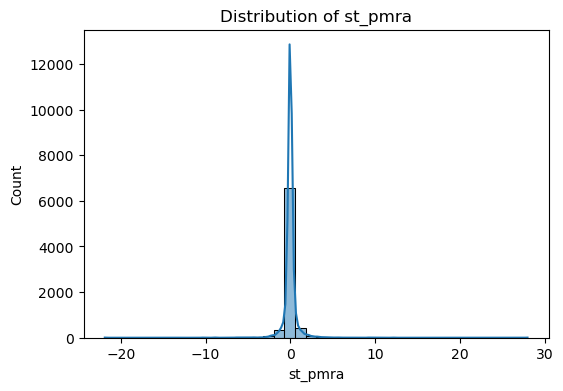

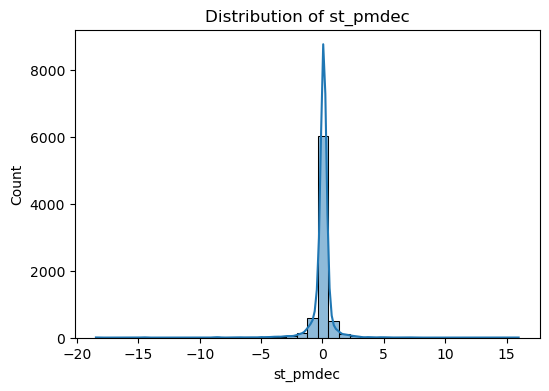

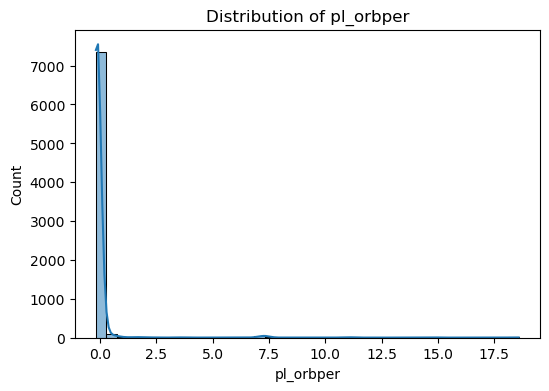

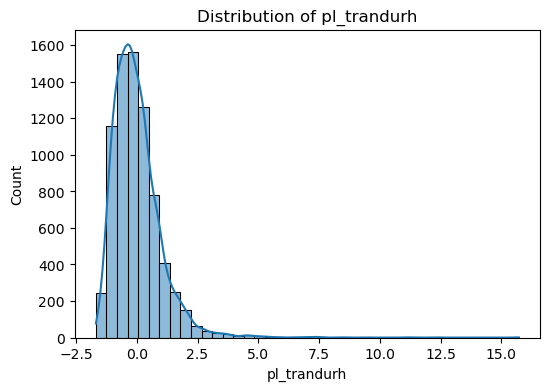

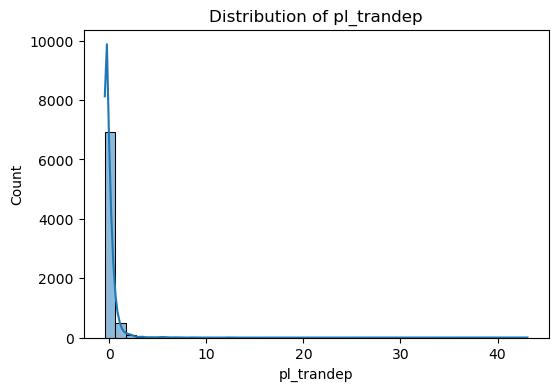

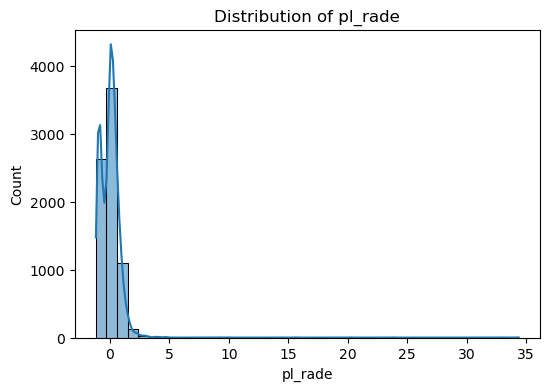

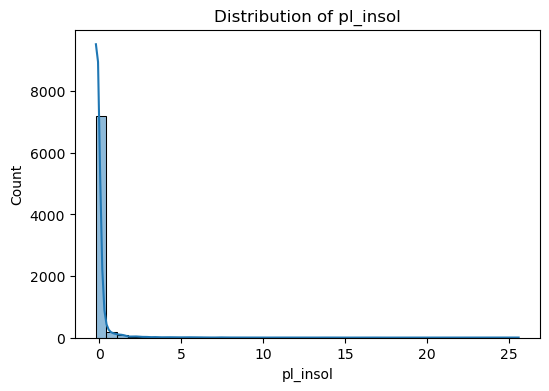

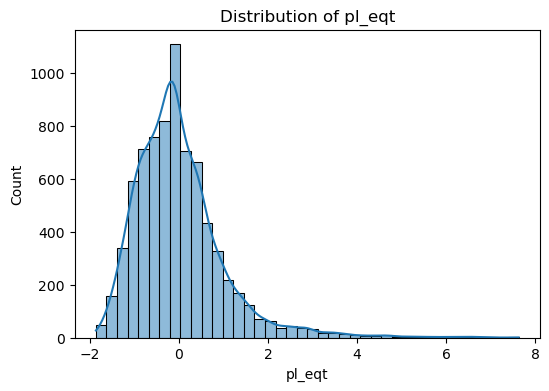

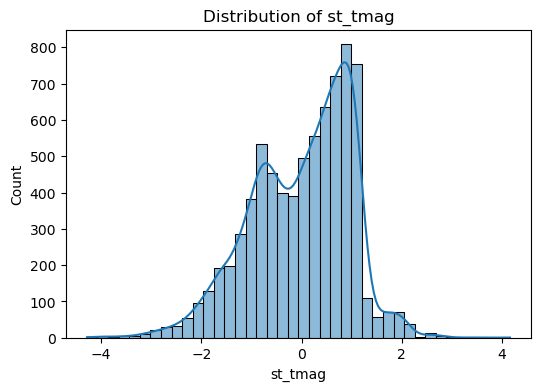

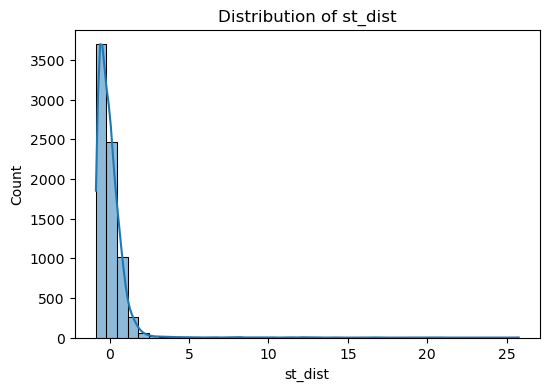

In [ ]:
# Histogram - Distribution plots
for col in eda_cont_cols[:10]:  # limit to first 10 for speed
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

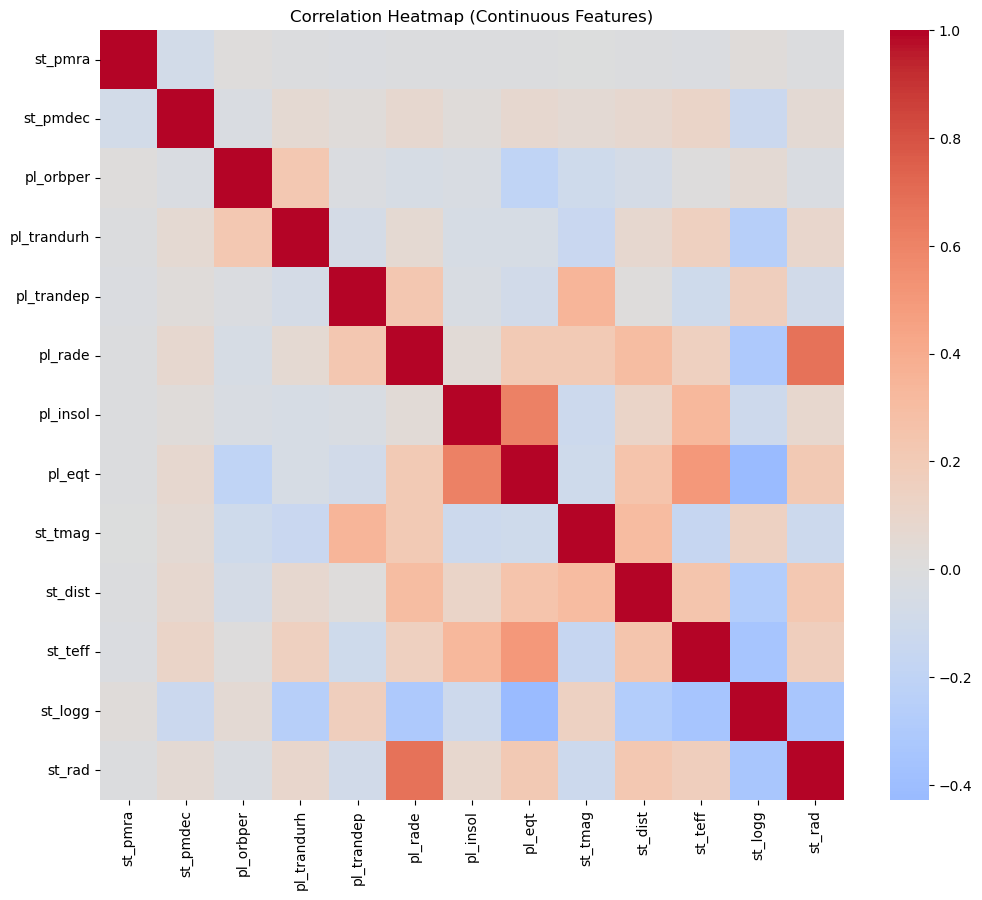

In [ ]:
# Correlation heatmap (continuous only)
plt.figure(figsize=(12, 10))
sns.heatmap(df[eda_cont_cols].corr(), cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_28864\1712850953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


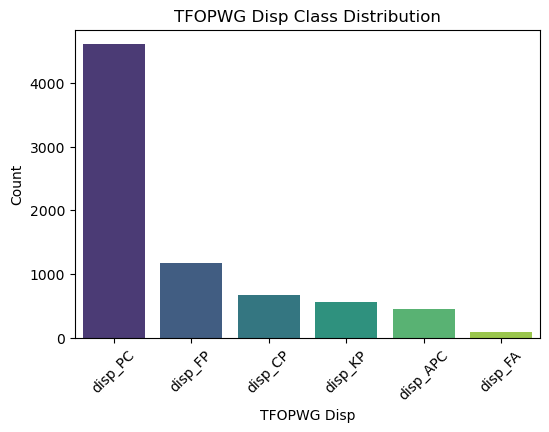

In [ ]:
# Class Balance Visualization
class_counts = df[dummy_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("TFOPWG Disp Class Distribution")
plt.ylabel("Count")
plt.xlabel("TFOPWG Disp")
plt.xticks(rotation=45)
plt.show()

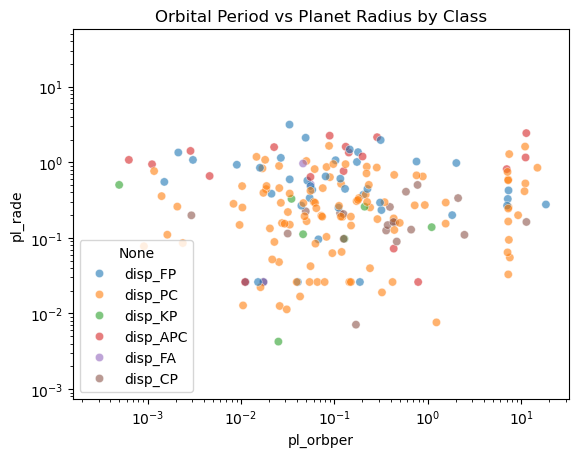

In [ ]:
# Feature Relationships by Class
sns.scatterplot(
    data=df, x="pl_orbper", y="pl_rade",
    hue=df[dummy_cols].idxmax(axis=1), alpha=0.6
)
plt.xscale("log")
plt.yscale("log")
plt.title("Orbital Period vs Planet Radius by Class")
plt.show()

In [ ]:
# Group-by Analysis
grouped = df.groupby(df[dummy_cols].idxmax(axis=1))[["pl_rade", "pl_trandep", "st_teff"]].mean()
print(grouped)

           pl_rade  pl_trandep   st_teff
disp_APC  0.349814    0.173037  0.187939
disp_CP  -0.506285   -0.071548 -0.505283
disp_FA  -0.513411   -0.270675 -0.188294
disp_FP   0.208204   -0.008816  0.309360
disp_KP   0.183471    0.174939 -0.091581
disp_PC  -0.025815   -0.019965 -0.009400


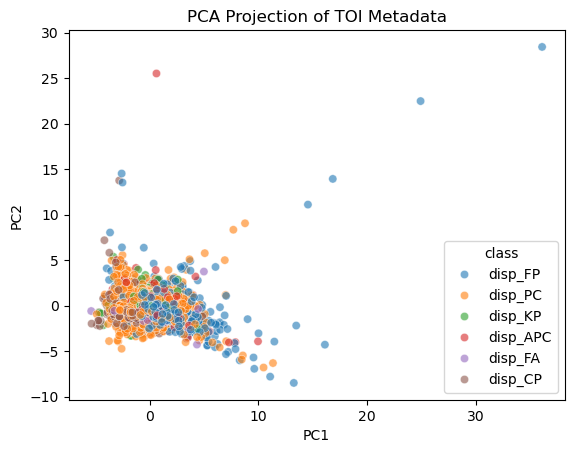

In [ ]:
# Dimensionality Reduction (PCA)
from sklearn.decomposition import PCA

X = df[eda_cont_cols].fillna(0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = df[dummy_cols].idxmax(axis=1)

sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="class", alpha=0.6)
plt.title("PCA Projection of TOI Metadata")
plt.show()


Conclusion: From the series of plots, it becomes evident that the dataset functions more as a collection of metadata and categorical labels rather than a conventional structure exhibiting clear independent–dependent variable relationships. The observed variations are driven primarily by discrete features and identifiers, underscoring the importance of classification-oriented attributes over continuous trends. Notably, the Positive Candidate class emerges as the dominant category across the dummy variables, exhibiting the most compact and consistent distributions. This dominance highlights its central role in shaping the dataset’s statistical profile and suggests that future modeling efforts may need to account for class imbalance and the strong influence of categorical encodings.

### Borneo ExoHunters Pipeline

<p style="text-align:center">
    <img src="https://github.com/nathanyap17/ssac_2025/blob/master/assets/Flow_chart.jpg?raw=1" alt="Data Pipeline: CNN Model"  />
    </a>
</p>

##### Import Dependencies

In [ ]:
%pip install lightkurve

Note: you may need to restart the kernel to use updated packages.


##### Understanding Data

In [ ]:
# Light curves - dependencies for MAST Light Curves
import pandas as pd
import lightkurve as lk

c:\Users\USER\anaconda3\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
# Import and parse the tid column
df = pd.read_csv('TOI_2025_wrangled_scaled.csv', header=0)
tids = df['tid'].dropna().astype(int).unique()

In [ ]:
lightcurves = {}

for tid in tids[:10]:
    try:
        print(f"Searching TIC {tid}...")
        search_result = lk.search_lightcurve(f"TIC {tid}", mission="TESS", author="SPOC")

        if len(search_result) == 0:
            print(f"No light curve found for TIC {tid}")
            continue

        # Download and filter quality before stitching
        lc_collection = search_result.download_all()
        for lc in lc_collection:
            lc = lc[lc.quality == 0]  # Keep only good quality data
        lc = lc_collection.stitch()  # Stitch filtered curves
        lightcurves[tid] = lc

        print(f"Downloaded TIC {tid}, length: {len(lc.flux)}")

    except Exception as e:
        print(f"Error with TIC {tid}: {e}")

Searching TIC 50365310...
Downloaded TIC 50365310, length: 121694
Searching TIC 88863718...
Downloaded TIC 88863718, length: 372825
Searching TIC 124709665...
Downloaded TIC 124709665, length: 121953
Searching TIC 106997505...
Downloaded TIC 106997505, length: 17329
Searching TIC 238597883...
Downloaded TIC 238597883, length: 121711
Searching TIC 169904935...
Downloaded TIC 169904935, length: 121681
Searching TIC 156115721...
Downloaded TIC 156115721, length: 121643
Searching TIC 65212867...
Downloaded TIC 65212867, length: 120919
Searching TIC 440801822...
Downloaded TIC 440801822, length: 173132
Searching TIC 107782586...
Downloaded TIC 107782586, length: 514043


In [ ]:
lightcurves

{np.int64(50365310): <TessLightCurve length=121694 LABEL="TIC 50365310" SECTOR=34 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
        time             flux      ...   pos_corr1      pos_corr2   
                                   ...      pix            pix      
        Time           float32     ...    float32        float32    
 ------------------ -------------- ... -------------- --------------
 2228.7552925312602            ——— ... -1.8168574e-03  7.6097287e-02
  2228.755524014501            ——— ... -9.1880206e-03  6.5594152e-02
 2228.7557554972773            ——— ...  9.3199303e-03  4.6777599e-02
  2228.755986980519            ——— ...  1.7408178e-03  3.4673970e-02
   2228.75621846376            ——— ... -1.3915600e-02  8.0682434e-02
  2228.756449946536            ——— ...  9.5078936e-03  3.3296466e-02
  2228.756681429778            ——— ... -8.3514787e-03  8.4124021e-02
 2228.7569129130193            ——— ...  7.1365661e-03  4.5930989e-02
  2228.757144395795            ——— ... -1.2440769e-02

In [ ]:
# Pre-processing Light Curves
lc = lc.remove_nans()
lc = lc.normalize()
lc = lc.flatten(window_length=401)
lc = lc.remove_outliers(sigma=5)


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

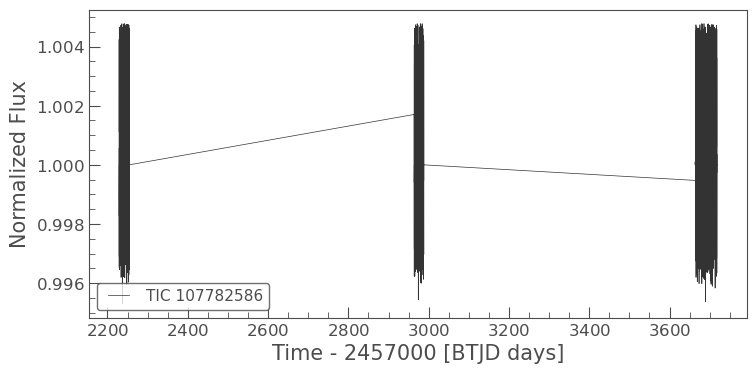

In [ ]:
lc.plot()

In [ ]:
import numpy as np

In [ ]:
pg = lc.to_periodogram(method="bls", period=np.linspace(0.5, 20, 10000))
pg.plot()

`period` contains 8645598 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

##### Define & Initialise Data Pre-Processing Pipelines

In [ ]:
# Storing lightcurves data in arrays - for 1D Convolutional Neural Networks
def saveLightCurves(lightcurves, labels, filename='lightcurve_dataset.npz'):
    x, time, y, tids = [], [], [], []
    for tid, lc in lightcurves.items():
        # Store arrays
        x.append(lc.flux.value)
        time.append(lc.time.value)
        y.append(labels.get(tid, None))
        tids.append(tid)

    # Convert to numpy arrays
    x = np.array(x, dtype=object) # use dtype=object if lengths differ
    time = np.array(time, dtype=object)
    y = np.array(y)
    tids = np.array(tids)

    np.savez(filename, x=x, time=time, y=y, tids=tids)
    print(f'✅ Saved {len(X)} lightcurves to {filename}')

##### Load the Dataset Later

In [ ]:
# Load the dataset later
def writeLightCurves(filename='lightcurve_dataset.npz'):
    data = np.load(filename, allow_pickle=True)
    x = data['x']
    time = data['time']
    y = data['y']
    tids = data['tids']
    print(f'✅ Loaded {len(x)} lightcurves from {filename}')
    return x, time, y, tids

##### Visualisation Function (Optional)

In [ ]:
import matplotlib.pyplot as plt

def plotLightCurves(time, flux, tid=None, label=None):
    plt.figure(figsize=(10, 4))
    plt.plot(time, flux, "k.", markersize=1)
    plt.xlabel("Time (BTJD days)")
    plt.ylabel("Normalized Flux")
    title = f"TIC {tid}" if tid else "Light Curve"
    if label is not None:
        title += f" (Label: {label})"
    plt.title(title)
    plt.show()


##### Collecting TESS Light Curves Data

In [ ]:
from tqdm import tqdm

lightcurves = {}

for tid in tqdm(tids[:200], desc="Downloading lightcurves"):
    try:
        search_result = lk.search_lightcurve(f"TIC {tid}", mission="TESS", author="SPOC")

        if len(search_result) == 0:
            print(f"No light curve found for TIC {tid}")
            continue

        # Download one at a time instead of all at once
        lc_list = []
        for sr in search_result:
            try:
                lc = sr.download()
                if lc is not None:
                    lc = lc[lc.quality == 0]  # Keep only good quality data
                    lc_list.append(lc)
            except Exception as sub_e:
                print(f"  Skipped one sector for TIC {tid}: {sub_e}")

        # Stitch all downloaded light curves for this TIC
        if len(lc_list) > 0:
            stitched = lc_list[0]
            if len(lc_list) > 1:
                stitched = lc_list[0].stitch(lc_list[1:])
            lightcurves[tid] = stitched

    except Exception as e:
        print(f"Error with TIC {tid}: {e}")

In [ ]:
# Save dataset
saveLightCurves()

<hr>

## <h4 align='center'>Borneo Data Pioneers - NASA Space Apps Challenge 2025. </h3>